In [1]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('Final_30_sessions_re_categorize.csv')

In [4]:
print("Original Dataset:")
print(data.head())

Original Dataset:
      Video ID  Session  View Count  Like Count  Comment Count Video Category  \
0  mb5ldcr1jbA        1      273046        1273              0           Info   
1  rtLGwJF9Jxc        1       93939         568              0     Recreation   
2  HAOgdVdSSkA        1      647685           0              6           Info   
3  WWeOBvAvwrY        1       41646        6085            998           Info   
4  WunqF6zQnbI        1       52315        1747             27           Info   

    Video Published At  
0  2024-10-21 19:10:34  
1  2024-10-21 18:45:33  
2  2024-10-21 18:41:24  
3  2024-10-21 18:31:26  
4  2024-10-21 18:10:08  


In [5]:
# Step 2: Fill Missing Video IDs in Sessions
# Create a full grid of all sessions and video IDs
unique_sessions = data['Session'].unique()
unique_videos = data['Video ID'].unique()

# Generate a complete grid
complete_grid = pd.MultiIndex.from_product(
    [unique_sessions, unique_videos], names=['Session', 'Video ID']
).to_frame(index=False)

In [6]:
# Merge the complete grid with the dataset
data_filled = pd.merge(complete_grid, data, on=['Session', 'Video ID'], how='left')

In [7]:
data_filled['View Count'] = data_filled['View Count'].fillna(0)
data_filled['Like Count'] = data_filled['Like Count'].fillna(0)
data_filled['Comment Count'] = data_filled['Comment Count'].fillna(0)
data_filled['Video Category'] = data_filled['Video Category'].fillna('Unknown')

In [8]:
# Sort the data by Session and Video ID
data_filled = data_filled.sort_values(by=['Session', 'Video ID']).reset_index(drop=True)

In [9]:
print("Filled Dataset:")
print(data_filled.head(100))

Filled Dataset:
    Session     Video ID  View Count  Like Count  Comment Count  \
0         1  -n0waD4qzI4     16245.0       412.0            6.0   
1         1  00-9NCfhVF8     12343.0      1634.0           28.0   
2         1  3s6uanj_5DY      9183.0       679.0           70.0   
3         1  6iG4Zp8HLOA    220840.0      4425.0            0.0   
4         1  6kKE4Rurmmk      7085.0       693.0           77.0   
..      ...          ...         ...         ...            ...   
95        2  uDVNRYxIMRE     75634.0       354.0            0.0   
96        2  uDvNq7vtGnM      5025.0       182.0           40.0   
97        2  yGLEpVbJm40   1164984.0     31060.0         7651.0   
98        2  zToiY455lhQ    807003.0    132297.0         2574.0   
99        2  zZsgnPmP6lg     36639.0      3743.0           19.0   

   Video Category   Video Published At  
0      Recreation  2024-10-21 15:00:06  
1      Recreation  2024-10-21 11:50:09  
2      Recreation  2024-10-21 14:26:44  
3            In

In [10]:
features = ['View Count', 'Like Count', 'Comment Count']
scaler = MinMaxScaler()

In [11]:
data_filled[features] = scaler.fit_transform(data_filled[features])

In [12]:
def create_video_sequences(data, sequence_length):
    X, y = [], []
    for video in data['Video ID'].unique():
        video_data = data[data['Video ID'] == video].sort_values(by='Session')[features].values
        for i in range(len(video_data) - sequence_length):
            X.append(video_data[i:i + sequence_length])
            y.append(video_data[i + sequence_length, 0])  # Predicting 'View Count'
    return np.array(X), np.array(y)


In [13]:
# Number of past sessions used to predict the next session
sequence_length = 5 

In [14]:
X, y = create_video_sequences(data_filled, sequence_length)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
#Build the LSTM Model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [18]:
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0045 - val_loss: 2.5082e-04
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8569e-04 - val_loss: 6.7931e-05
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5115e-04 - val_loss: 1.5490e-04
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6459e-04 - val_loss: 5.0784e-04
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7300e-04 - val_loss: 2.1634e-05
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5500e-04 - val_loss: 4.0454e-05
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0554e-04 - val_loss: 2.5517e-04
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3422e-04 - val_loss: 1.9841e-04
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0516e-04 - val_loss: 9.4326e-05
Epoch 10/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1560e-04 - val_loss: 1.1000e-04
Epoch 11/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5982e-04 - val_loss: 6

In [19]:
predictions = model.predict(X_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [20]:
# Expanding the 'predictions' array to match the shape required for inverse transformation
# This step adds extra columns filled with zeros for features not being predicted.
# The number of added columns is (len(features) - 1), assuming only one feature is predicted (e.g., 'View Count').
predictions_expanded = np.concatenate(
    (predictions, np.zeros((predictions.shape[0], len(features) - 1))),  # Add zeros to match feature dimensions
    axis=1  # Concatenate along the column axis
)

# Expanding the 'y_test' array to match the shape required for inverse transformation
# This reshapes the true target values into a compatible shape and adds zeros for other features.
y_test_expanded = np.concatenate(
    (y_test.reshape(-1, 1),  # Reshape 'y_test' to add a new axis for concatenation
     np.zeros((y_test.shape[0], len(features) - 1))),  # Add zeros to match feature dimensions
    axis=1  # Concatenate along the column axis
)

In [21]:
# Rescaling the predictions back to the original scale using the inverse_transform method of the scaler
# Only the first column (the target feature, e.g., 'View Count') is used from the expanded array.
predictions_rescaled = scaler.inverse_transform(predictions_expanded)[:, 0]

# Rescaling the true target values (y_test) back to the original scale for comparison
# Again, only the first column (the target feature) is taken after inverse transformation.l
y_test_rescaled = scaler.inverse_transform(y_test_expanded)[:, 0]

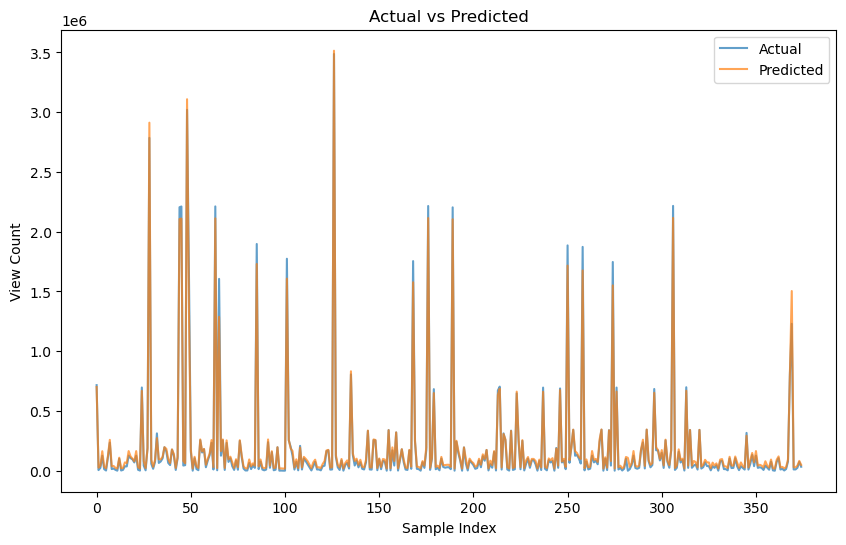

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual', alpha=0.7)
plt.plot(predictions_rescaled, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('View Count')
plt.legend()
plt.show()

### Explanation of the Graph

1. **X-axis (Sample Index)**:
   - Each index on the X-axis corresponds to a specific **video in a session**.
   - For example:
     - Index 1 represents video 1 in session 1.
     - Index 2 represents video 2 in session 1, and so on.

2. **Y-axis (View Count)**:
   - This represents the **view count** (in the original scale, after rescaling).

3. **Actual Values (Blue Line)**:
   - The blue line represents the **true view counts** for each video at the corresponding sample index.

4. **Predicted Values (Orange Line)**:
   - The orange line represents the **predicted view counts** generated by the model for each video at the corresponding sample index.

The test size is 0.3 so that there is 0.3*14XX where approximately 400 video is plotted.


In [23]:
model.save('lstm_model.h5')
print("Model saved successfully!")

Model saved successfully!


In [24]:
from tensorflow.keras.models import load_model

# Load the saved LSTM model we trained
model = load_model('lstm_model.h5')
print("Model loaded successfully!")


Model loaded successfully!


In [25]:
import numpy as np
import pandas as pd
from keras.models import load_model


In [26]:
data = pd.read_csv('Final_30_sessions_re_categorize.csv')


In [27]:
video_id = 'mb5ldcr1jbA'
video_data = data[data['Video ID'] == video_id]

# Extract the view count series to use for prediction
view_counts = video_data['View Count'].values
 

In [28]:
video_data

,Video ID,Session,View Count,Like Count,Comment Count,Video Category,Video Published At
0,mb5ldcr1jbA,1,273046,1273,0,Info,2024-10-21 19:10:34
50,mb5ldcr1jbA,2,275310,1279,0,Info,2024-10-21 19:10:34
100,mb5ldcr1jbA,3,276646,1281,0,Info,2024-10-21 19:10:34
150,mb5ldcr1jbA,4,277496,1287,0,Info,2024-10-21 19:10:34
200,mb5ldcr1jbA,5,278589,1300,0,Info,2024-10-21 19:10:34
250,mb5ldcr1jbA,6,280162,1323,1,Info,2024-10-21 19:10:34
300,mb5ldcr1jbA,7,283305,1354,2,Info,2024-10-21 19:10:34
350,mb5ldcr1jbA,8,290208,1373,2,Info,2024-10-21 19:10:34
400,mb5ldcr1jbA,9,296018,1392,2,Info,2024-10-21 19:10:34
450,mb5ldcr1jbA,10,301444,1403,2,Info,2024-10-21 19:10:34


In [29]:
view_counts

array([273046, 275310, 276646, 277496, 278589, 280162, 283305, 290208,
       296018, 301444, 305825, 309264, 312323, 314550, 317154, 318754,
       320449, 322123, 323542, 334623, 335094, 335337, 335399, 335607,
       336040, 336780, 337712, 338985, 339182, 340450])

In [30]:
window_size = 30
input_view = video_data['View Count'].values[-window_size:]
input_like = video_data['Like Count'].values[-window_size:]
input_comment = video_data['Comment Count'].values[-window_size:]

In [31]:
input_data = np.column_stack((input_view, input_like, input_comment))

In [32]:
# Reshape to (1, 30, 3) because model expects 3D input: (batch, timesteps, features)
input_sequence = input_data.reshape(1, window_size, 3)

# Number of future steps to predict
future_steps = 20
predictions = []

In [33]:
for i in range(future_steps):
    # Predict the next value (this returns the predicted View Count)
    predicted = model.predict(input_sequence, verbose=0)  # shape: (1,1)
    predicted_view = predicted[0, 0]

    # Store the prediction
    predictions.append(predicted_view)

    # Now we need to update the input_sequence for the next prediction:
    # Slide the window forward by 1:
    # Remove the first timestep and add the new predicted View Count at the end.
    # For Like Count and Comment Count, since we have no future data, let's keep them
    # the same as the last known timestep.
    last_like = input_sequence[0, -1, 1]    # last timestep like count
    last_comment = input_sequence[0, -1, 2] # last timestep comment count

    # Create a new row with the predicted view and the same like/comment values
    new_row = np.array([[predicted_view, last_like, last_comment]])  # shape: (1,3)

    # Slide the sequence:
    current_sequence = input_sequence[0, 1:, :]       # shape: (29, 3)
    new_sequence = np.vstack([current_sequence, new_row])  # shape: (30, 3)

    # Reshape back to (1, 30, 3) for next iteration
    input_sequence = new_sequence.reshape(1, window_size, 3)


In [34]:
# Print the predictions
print("Predicted View Counts for the next 20 sessions:")
for idx, val in enumerate(predictions, start=1):
    print(f"Future session {30 + idx}: {val}")

Predicted View Counts for the next 20 sessions:
Future session 31: 1.179910659790039
Future session 32: 1.4271451234817505
Future session 33: 1.4824789762496948
Future session 34: 1.5074127912521362
Future session 35: 1.5193861722946167
Future session 36: 1.5291928052902222
Future session 37: 1.5376594066619873
Future session 38: 1.544934868812561
Future session 39: 1.5510704517364502
Future session 40: 1.556159257888794
Future session 41: 1.5603259801864624
Future session 42: 1.5637062788009644
Future session 43: 1.5664303302764893
Future session 44: 1.5686382055282593
Future session 45: 1.57160484790802
Future session 46: 1.606502890586853
Future session 47: 1.6090211868286133
Future session 48: 1.5899131298065186
Future session 49: 1.5854535102844238
Future session 50: 1.5857608318328857


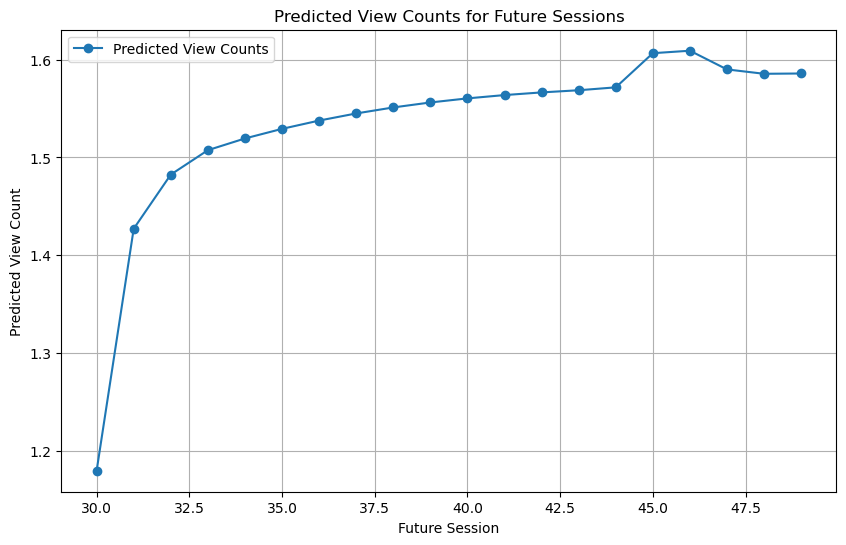

In [35]:
import matplotlib.pyplot as plt

# Create a range of future sessions
future_sessions = [30 + idx for idx in range(len(predictions))]

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(future_sessions, predictions, marker='o', label='Predicted View Counts')
plt.title('Predicted View Counts for Future Sessions')
plt.xlabel('Future Session')
plt.ylabel('Predicted View Count')
plt.grid(True)
plt.legend()
plt.show()
